In [1]:
import importlib

import common

importlib.reload(common)

<module 'common' from 'C:\\Users\\j\\IdeaProjects\\fiit_masters_thesis_project\\jupyter\\common.py'>

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlalchemy

from common import create_engine
from common import display_all
from common import figsize
from common import save_df


from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters() # converters e.g. for datetime in plots

In [3]:
engine = create_engine('db-conf.json', 'local')
pd.sql = lambda sql: pd.read_sql(sqlalchemy.text(sql), con=engine)

Nacitanie dat z db (live data z monant snapshotu)

In [4]:
create_view_query = '''
DROP MATERIALIZED VIEW IF EXISTS article_fb_latest;
CREATE MATERIALIZED VIEW article_fb_latest AS
(
SELECT sbq.url, sbq.sync_date, sbq.reaction_count, sbq.comment_count, sbq.share_count
FROM (
         SELECT afe.*, row_number() OVER (PARTITION BY url ORDER BY sync_date DESC) as rn
         FROM article_fb_engagement afe
     ) sbq
WHERE sbq.rn = 1)
'''

with engine.connect() as connection:
    connection.execute(create_view_query)

In [5]:
fetch_data_query = '''
SELECT a.id,
       a.url,
       title,
       perex,
       body,
       published_at,
       extracted_at,
       a.source_id,
       category,
       other_info,
       aut.name                                       as author_name,
       s.id                                           as source_id,
       s.name                                         as source_name,
       s.url                                          as source_url,
       stype                                          as source_type,
       is_reliable::integer                           as source_is_reliable,
       sync_date                                      as fb_sync_date,
       reaction_count                                 as fb_reaction_count,
       comment_count                                  as fb_comment_count,
       share_count                                    as fb_share_count,
       (reaction_count + comment_count + share_count) as fb_popularity
FROM article a
         JOIN source s on a.source_id = s.id
         JOIN (SELECT * FROM article_fb_latest) p ON a.url = p.url
         JOIN author aut on a.author_id = aut.id
WHERE s.url !~ '(\.sk$)|(\.cz$)' -- remove cz/sk sources
  AND s.name NOT IN ('badatel.net', -- cz/sk portals not using cz/sk domain
                     'energiezivota.com')
  AND a.published_at IS NOT NULL
  AND s.is_reliable IS NOT NULL;
'''

df = pd.sql(fetch_data_query)
df_copy = df.copy()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168191 entries, 0 to 168190
Data columns (total 21 columns):
id                    168191 non-null int64
url                   168191 non-null object
title                 168191 non-null object
perex                 144826 non-null object
body                  167958 non-null object
published_at          168191 non-null datetime64[ns]
extracted_at          168191 non-null datetime64[ns]
source_id             168191 non-null int64
category              141084 non-null object
other_info            168187 non-null object
author_name           168191 non-null object
source_id             168191 non-null int64
source_name           168191 non-null object
source_url            168191 non-null object
source_type           168191 non-null object
source_is_reliable    168191 non-null int64
fb_sync_date          168191 non-null datetime64[ns]
fb_reaction_count     168191 non-null int64
fb_comment_count      168191 non-null int64
fb_share_count  

In [7]:
df.head()

,id,url,title,perex,body,published_at,extracted_at,source_id,category,other_info,...,source_id,source_name,source_url,source_type,source_is_reliable,fb_sync_date,fb_reaction_count,fb_comment_count,fb_share_count,fb_popularity
0,355165,http://blog.healthadvocate.com/2011/08/smarter...,Smarter eating at buffets,<p>It&#8217;s easy to be fooled into thinking ...,It’s easy to be fooled into thinking that dini...,2011-08-02 17:06:00,2019-09-06 04:02:15.203668,223,"{""Health Tips"",Nutrition,""Health Information"",...","{'tags': ['Healthy Eating', 'Nutrition', 'Well...",...,223,healthadvocate.com,http://healthadvocate.com,news_website,1,2019-10-14 21:53:23.370260,0,0,0,0
1,355267,http://blog.healthadvocate.com/2013/01/soups-on/,Soup&#8217;s on!,"<p>During the colder months, eating a bowl of ...","During the colder months, eating a bowl of sou...",2013-01-15 21:31:00,2019-09-06 04:02:58.622688,223,{Nutrition},"{'tags': [], 'updated_at': '2018-03-02T11:44:17'}",...,223,healthadvocate.com,http://healthadvocate.com,news_website,1,2019-10-14 21:53:24.046867,0,0,0,0
2,355283,http://blog.healthadvocate.com/2013/04/dancing...,Dancing Your Way to Better Health,"<p>Do you enjoy dancing? If so, you may want t...","Do you enjoy dancing? If so, you may want to c...",2013-04-26 14:43:05,2019-09-06 04:03:06.256547,223,"{Wellness,Fitness}","{'tags': [], 'updated_at': '2018-03-02T11:44:16'}",...,223,healthadvocate.com,http://healthadvocate.com,news_website,1,2019-10-14 21:53:24.047008,0,0,0,0
3,355307,http://blog.healthadvocate.com/2013/07/how-eap...,How EAPs Can Benefit a Company’s Employees…and...,<p>Job stress is a leading source of stress fo...,Job stress is a leading source of stress for A...,2013-07-09 17:24:00,2019-09-06 04:03:15.869432,223,"{""Stress Management"",""Employee Assistance Prog...","{'tags': [], 'updated_at': '2018-03-02T11:43:40'}",...,223,healthadvocate.com,http://healthadvocate.com,news_website,1,2019-10-14 21:53:24.384061,0,0,0,0
4,355603,http://blog.healthadvocate.com/2015/05/healthy...,Healthy Reasons to Exercise,<p>We’re frequently exposed to public service ...,We’re frequently exposed to public service ann...,2015-05-19 11:55:40,2019-09-06 04:07:58.978488,223,"{Wellness,Fitness}","{'tags': [], 'updated_at': '2018-03-02T11:37:20'}",...,223,healthadvocate.com,http://healthadvocate.com,news_website,1,2019-10-14 21:53:26.547686,2,0,4,6


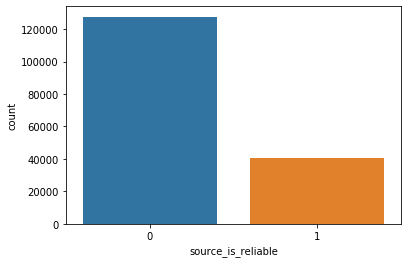

In [8]:
sns.countplot(x='source_is_reliable', data=df)

In [9]:
df['fb_popularity'].describe().apply(lambda x: '%.3f' % x)

count     168191.000
mean        1296.037
std        25938.851
min            0.000
25%            0.000
50%            1.000
75%           88.000
max      5197586.000
Name: fb_popularity, dtype: object

In [10]:
def draw_publishing_per_year(df):
    published_in_year = df.published_at.apply(lambda x: x.year)
    with figsize(plt, 20, 5):
        cplt = sns.countplot(published_in_year, color='black')
        cplt.set(xlabel='Rok publikovania', ylabel='Počet článkov')
        return cplt


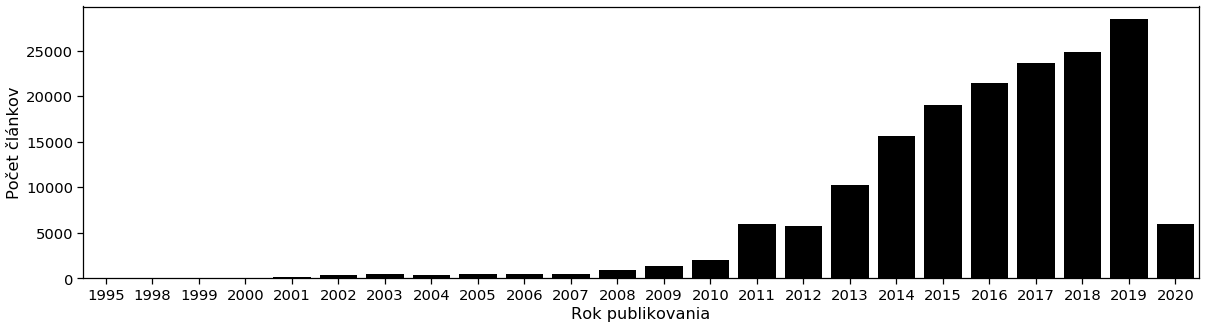

In [11]:
with sns.plotting_context("notebook", font_scale=1.35):
    draw_publishing_per_year(df).get_figure().savefig('export/clanky-per-rok.png')

Cut the articles so we use only those from 2011 - now

In [12]:
df = df[df.published_at > '2011-01-01']

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160897 entries, 0 to 168190
Data columns (total 21 columns):
id                    160897 non-null int64
url                   160897 non-null object
title                 160897 non-null object
perex                 137532 non-null object
body                  160668 non-null object
published_at          160897 non-null datetime64[ns]
extracted_at          160897 non-null datetime64[ns]
source_id             160897 non-null int64
category              133794 non-null object
other_info            160893 non-null object
author_name           160897 non-null object
source_id             160897 non-null int64
source_name           160897 non-null object
source_url            160897 non-null object
source_type           160897 non-null object
source_is_reliable    160897 non-null int64
fb_sync_date          160897 non-null datetime64[ns]
fb_reaction_count     160897 non-null int64
fb_comment_count      160897 non-null int64
fb_share_count  

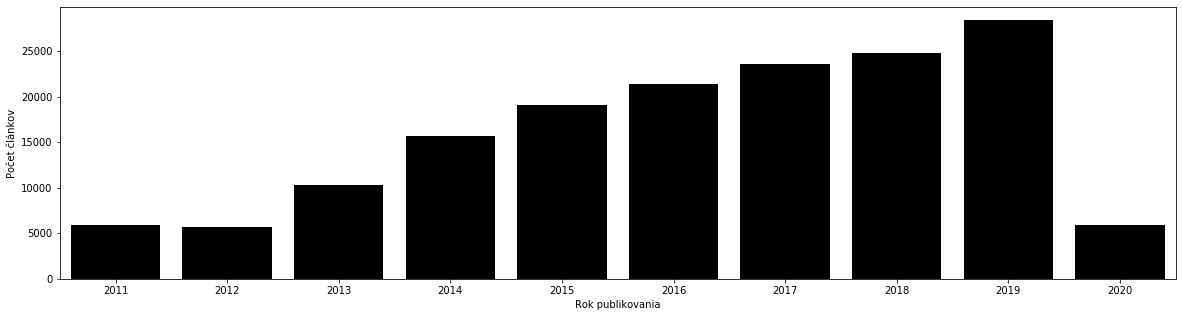

In [14]:
draw_publishing_per_year(df)

In [15]:
df[['source_name', 'source_is_reliable']].groupby('source_name').first()['source_is_reliable'].value_counts()

0    47
1    20
Name: source_is_reliable, dtype: int64

In [16]:
display_all(df[['source_is_reliable', 'fb_reaction_count', 'fb_comment_count', 'fb_share_count']] .groupby('source_is_reliable').describe())

fb_reaction_count                                       \
                               count         mean           std  min  25%   
source_is_reliable                                                          
0                           121526.0  1084.300232  22340.439017  0.0  0.0   
1                            39371.0   297.677123   3172.341011  0.0  0.0   

                                         fb_comment_count              \
                    50%   75%        max            count        mean   
source_is_reliable                                                      
0                   0.0  52.0  3929532.0         121526.0  226.685187   
1                   0.0  44.0   297646.0          39371.0   73.107643   

                                                              fb_share_count  \
                            std  min  25%  50%  75%       max          count   
source_is_reliable                                                             
0                   4523.525492  0.0  0.0  0.0  8.0  714968.0       121526.0   
1                    709.409807  0.0  0.0  0.0  6.0   45146.0        39371.0   

                                                                            
                          mean          std  min  25%  50%   75%       max  
source_is_reliable                                                          
0                   324.705734  4843.753629  0.0  0.0  1.0  36.0  572708.0  
1                   104.653781   916.062957  0.0  0.0  0.0  26.0   60159.0

In [18]:
df_gb_pop = df.groupby('source_url')['fb_popularity'].describe().sort_values('count', ascending=False)
df_gb_pop['is_reliable'] = df.groupby('source_url')['source_is_reliable'].first()
display_all(df_gb_pop)

,count,mean,std,min,25%,50%,75%,max,is_reliable
source_url,,,,,,,,,
http://naturalnews.com,22662.0,1168.524226,39723.184905,0.0,21.00,86.0,244.00,5197586.0,0
http://naturalnewsblogs.com,17768.0,86.843708,2293.899106,0.0,0.00,0.0,1.00,203855.0,0
http://neurosciencenews.com,13610.0,297.230198,4002.526318,0.0,0.00,0.0,78.00,294411.0,1
http://statnews.com,12987.0,230.584277,1908.394145,0.0,0.00,0.0,34.00,82773.0,1
http://healthnutnews.com,7505.0,1631.852498,23108.027610,0.0,4.00,198.0,768.00,1810067.0,0
http://naturalsociety.com,7250.0,10.417931,602.752769,0.0,0.00,0.0,0.00,49319.0,0
http://healthimpactnews.com,6379.0,370.223076,10802.447426,0.0,0.00,0.0,11.00,841807.0,0
http://themindunleashed.com,6053.0,9421.663638,63421.588310,0.0,0.00,45.0,1973.00,1858055.0,0
http://infowars.com,5951.0,55.579062,388.391299,0.0,0.00,0.0,10.00,16902.0,0


In [19]:
df[df.source_is_reliable == True].groupby('source_url')['fb_popularity'].describe().sort_values('count', ascending=False)

,count,mean,std,min,25%,50%,75%,max
source_url,,,,,,,,
http://neurosciencenews.com,13610.0,297.230198,4002.526318,0.0,0.00,0.0,78.00,294411.0
http://statnews.com,12987.0,230.584277,1908.394145,0.0,0.00,0.0,34.00,82773.0
http://sciencebasedmedicine.org,2479.0,806.377572,2325.651661,0.0,4.00,134.0,690.50,45781.0
http://medicinenet.com,1814.0,0.979603,7.894025,0.0,0.00,0.0,0.00,217.0
http://healthadvocate.com,1413.0,8.886058,98.267970,0.0,0.00,3.0,9.00,3678.0
http://vaxopedia.org,1094.0,77.163620,217.841914,0.0,1.00,17.0,60.75,3024.0
http://youngwomenshealth.org,961.0,7.421436,48.645854,0.0,0.00,0.0,3.00,903.0
http://nytimes.com,960.0,6496.068750,16730.984501,14.0,568.00,1684.0,5028.25,222535.0
http://webmd.com,855.0,2148.739181,15324.106374,2.0,57.50,241.0,855.00,355985.0


In [20]:
df[df.source_is_reliable == False].groupby('source_url')['fb_popularity'].describe().sort_values('count', ascending=False)

,count,mean,std,min,25%,50%,75%,max
source_url,,,,,,,,
http://naturalnews.com,22662.0,1168.524226,39723.184905,0.0,21.0,86.0,244.00,5197586.0
http://naturalnewsblogs.com,17768.0,86.843708,2293.899106,0.0,0.0,0.0,1.00,203855.0
http://healthnutnews.com,7505.0,1631.852498,23108.027610,0.0,4.0,198.0,768.00,1810067.0
http://naturalsociety.com,7250.0,10.417931,602.752769,0.0,0.0,0.0,0.00,49319.0
http://healthimpactnews.com,6379.0,370.223076,10802.447426,0.0,0.0,0.0,11.00,841807.0
http://themindunleashed.com,6053.0,9421.663638,63421.588310,0.0,0.0,45.0,1973.00,1858055.0
http://infowars.com,5951.0,55.579062,388.391299,0.0,0.0,0.0,10.00,16902.0
http://realfarmacy.com,4845.0,5231.854696,50071.002305,0.0,0.0,1.0,159.00,2165131.0
http://healthy-holistic-living.com,4311.0,8250.536071,56384.522197,0.0,0.0,3.0,476.50,1735454.0


### Save final data

In [21]:
save_df(df, 'final_data.pickle')